# Import Libraries

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from model import Model_LN
%matplotlib inline

In [2]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Data Statistics

In [3]:
simple_transforms = transforms.Compose([transforms.ToTensor()])
exp_train = datasets.CIFAR10('./data', train=True, download=True)
exp_test = datasets.CIFAR10('./data', train=True, download=False)
exp_train_data = exp_train.data
exp_test_data = exp_test.data
exp_data = np.concatenate((exp_train_data, exp_test_data), axis=0)

print(f'Shape: {exp_data.shape}')
print(f'Mean: {exp_data.mean(axis=(0,1,2))/255}')
print(f'STD: {exp_data.std(axis=(0,1,2))/255}')

Files already downloaded and verified
Shape: (100000, 32, 32, 3)
Mean: [0.49139968 0.48215841 0.44653091]
STD: [0.24703223 0.24348513 0.26158784]


# Initialize train and test transforms

In [4]:
# Training transform
train_transforms = transforms.Compose([transforms.RandomApply([transforms.RandAugment()], p=0.3),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])])

# Test transform
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])])

# transform to inverse effect of Normalization while ploting
inv_transform = transforms.Normalize([-0.49139968/0.24703223, -0.48215841/0.24348513, -0.44653091/0.26158784], [1/0.24703223, 1/0.24348513, 1/0.26158784])

# Download data

In [5]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Create data loader

In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Plot data

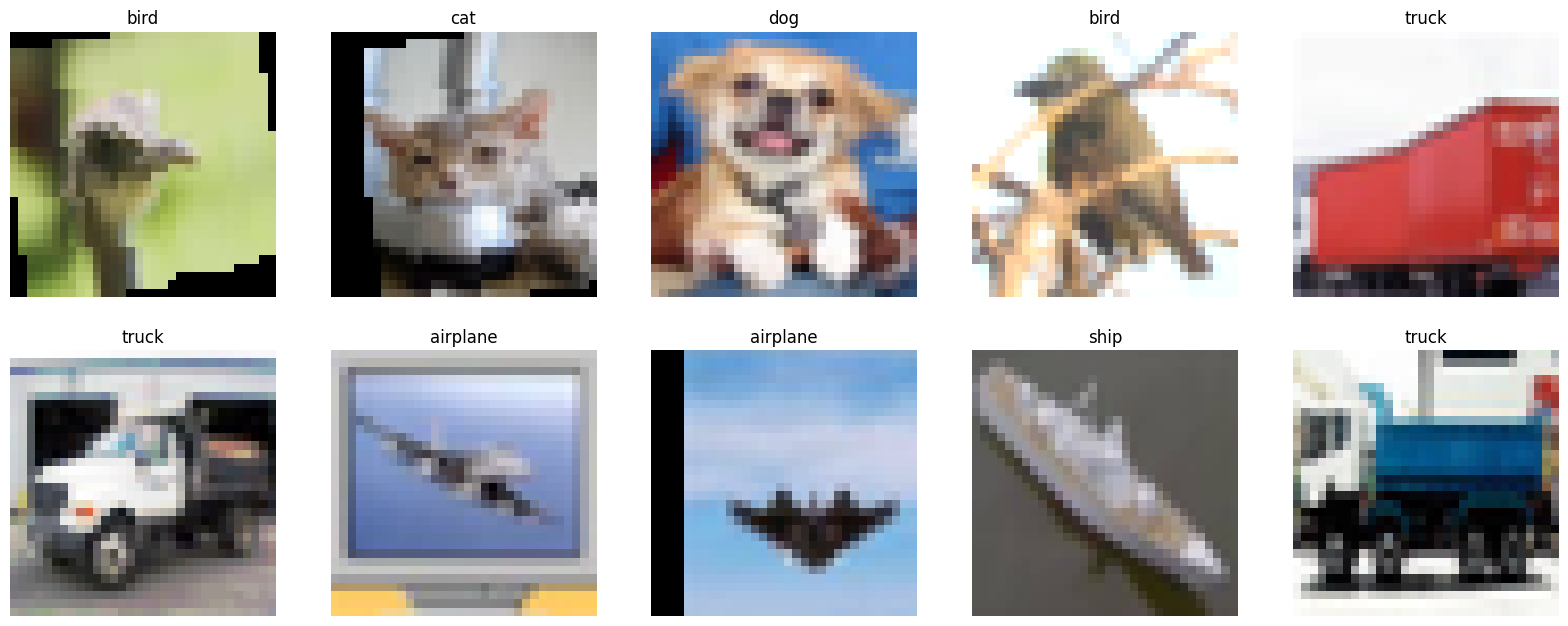

In [7]:
figure = plt.figure(figsize=(20,20))
num_of_images = 10
images, labels = next(iter(train_loader))
images = inv_transform(images)
for index in range(1, num_of_images + 1):
    plt.subplot(5, 5, index)
    plt.title(CLASS_NAMES[labels[index].numpy()])
    plt.axis('off')
    plt.imshow(np.transpose(images[index], (1, 2, 0)))

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_LN().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
         GroupNorm-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
         GroupNorm-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             128
        MaxPool2d-10            [-1, 8, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           2,304
        GroupNorm-12           [-1, 32, 16, 16]              64
             ReLU-13           [-1, 32, 16, 16]               0
          Dropout-14           [-1

In [10]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model =  Model_LN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


EPOCH: 0


Loss=1.7671349048614502 Batch_id=390 Accuracy=19.34: 100%|██████████| 391/391 [00:31<00:00, 12.24it/s]



Test set: Average loss: 1.8014, Accuracy: 2964/10000 (29.64%)

EPOCH: 1


Loss=1.4576834440231323 Batch_id=390 Accuracy=33.88: 100%|██████████| 391/391 [00:24<00:00, 16.25it/s]



Test set: Average loss: 1.6094, Accuracy: 4112/10000 (41.12%)

EPOCH: 2


Loss=1.5215400457382202 Batch_id=390 Accuracy=41.77: 100%|██████████| 391/391 [00:23<00:00, 16.88it/s]



Test set: Average loss: 1.5393, Accuracy: 4316/10000 (43.16%)

EPOCH: 3


Loss=1.2790133953094482 Batch_id=390 Accuracy=46.92: 100%|██████████| 391/391 [00:23<00:00, 16.76it/s]



Test set: Average loss: 1.3506, Accuracy: 4981/10000 (49.81%)

EPOCH: 4


Loss=1.190480351448059 Batch_id=390 Accuracy=51.76: 100%|██████████| 391/391 [00:24<00:00, 16.27it/s]



Test set: Average loss: 1.2323, Accuracy: 5554/10000 (55.54%)

EPOCH: 5


Loss=1.3442960977554321 Batch_id=390 Accuracy=55.75: 100%|██████████| 391/391 [00:23<00:00, 16.48it/s]



Test set: Average loss: 1.2244, Accuracy: 5728/10000 (57.28%)

EPOCH: 6


Loss=1.1200542449951172 Batch_id=390 Accuracy=58.03: 100%|██████████| 391/391 [00:24<00:00, 16.10it/s]



Test set: Average loss: 1.0674, Accuracy: 6112/10000 (61.12%)

EPOCH: 7


Loss=1.1823787689208984 Batch_id=390 Accuracy=61.03: 100%|██████████| 391/391 [00:23<00:00, 16.33it/s]



Test set: Average loss: 1.0632, Accuracy: 6158/10000 (61.58%)

EPOCH: 8


Loss=1.0232603549957275 Batch_id=390 Accuracy=61.80: 100%|██████████| 391/391 [00:24<00:00, 16.29it/s]



Test set: Average loss: 0.9793, Accuracy: 6541/10000 (65.41%)

EPOCH: 9


Loss=1.0976355075836182 Batch_id=390 Accuracy=63.58: 100%|██████████| 391/391 [00:23<00:00, 16.33it/s]



Test set: Average loss: 0.9468, Accuracy: 6639/10000 (66.39%)

EPOCH: 10


Loss=0.9093017578125 Batch_id=390 Accuracy=67.78: 100%|██████████| 391/391 [00:24<00:00, 16.19it/s]



Test set: Average loss: 0.8450, Accuracy: 7029/10000 (70.29%)

EPOCH: 11


Loss=0.8399887084960938 Batch_id=390 Accuracy=68.83: 100%|██████████| 391/391 [00:24<00:00, 16.28it/s]



Test set: Average loss: 0.8428, Accuracy: 7035/10000 (70.35%)

EPOCH: 12


Loss=1.032621145248413 Batch_id=390 Accuracy=69.40: 100%|██████████| 391/391 [00:23<00:00, 16.41it/s]



Test set: Average loss: 0.8358, Accuracy: 7083/10000 (70.83%)

EPOCH: 13


Loss=0.8819442987442017 Batch_id=390 Accuracy=69.44: 100%|██████████| 391/391 [00:23<00:00, 16.50it/s]



Test set: Average loss: 0.8232, Accuracy: 7129/10000 (71.29%)

EPOCH: 14


Loss=0.6185571551322937 Batch_id=390 Accuracy=69.58: 100%|██████████| 391/391 [00:23<00:00, 16.87it/s]



Test set: Average loss: 0.8315, Accuracy: 7086/10000 (70.86%)

EPOCH: 15


Loss=0.8409180641174316 Batch_id=390 Accuracy=70.08: 100%|██████████| 391/391 [00:24<00:00, 15.98it/s]



Test set: Average loss: 0.8062, Accuracy: 7178/10000 (71.78%)

EPOCH: 16


Loss=0.8021359443664551 Batch_id=390 Accuracy=70.06: 100%|██████████| 391/391 [00:24<00:00, 16.01it/s]



Test set: Average loss: 0.8190, Accuracy: 7151/10000 (71.51%)

EPOCH: 17


Loss=0.8360260725021362 Batch_id=390 Accuracy=70.47: 100%|██████████| 391/391 [00:23<00:00, 16.40it/s]



Test set: Average loss: 0.8073, Accuracy: 7161/10000 (71.61%)

EPOCH: 18


Loss=0.8581200838088989 Batch_id=390 Accuracy=70.67: 100%|██████████| 391/391 [00:24<00:00, 16.26it/s]



Test set: Average loss: 0.7993, Accuracy: 7227/10000 (72.27%)

EPOCH: 19


Loss=0.6894532442092896 Batch_id=390 Accuracy=70.95: 100%|██████████| 391/391 [00:23<00:00, 16.49it/s]



Test set: Average loss: 0.8277, Accuracy: 7090/10000 (70.90%)



Text(0.5, 1.0, 'Test Accuracy')

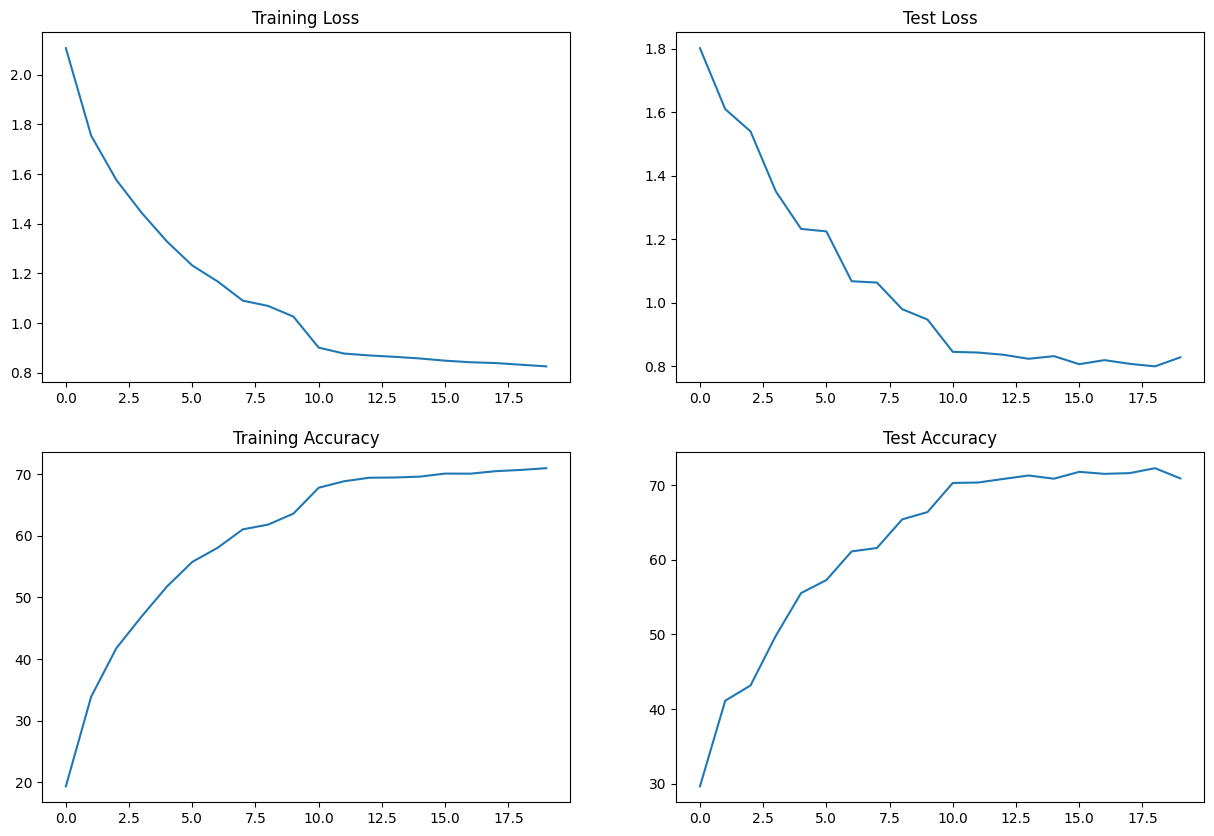

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [13]:
def plot_missclassified_images(model, test_loader):
  model.eval()

  missclassified_image_list = []
  label_list = []
  pred_list = []

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True)
      if len(missclassified_image_list) > 10:
        break
      for i in range(len(pred)):
        if pred[i] != target[i]:
          missclassified_image_list.append(data[i])
          label_list.append(CLASS_NAMES[target[i]])
          pred_list.append(CLASS_NAMES[pred[i]])

  figure = plt.figure(figsize=(20,20))
  num_of_images = 10
  for index in range(1, num_of_images + 1):
      plt.subplot(5, 5, index)
      plt.title(f'Actual: {label_list[index]} Prediction: {pred_list[index]}')
      plt.axis('off')
      image = inv_transform(missclassified_image_list[index])
      plt.imshow(np.transpose(image.cpu(), (1, 2, 0)))

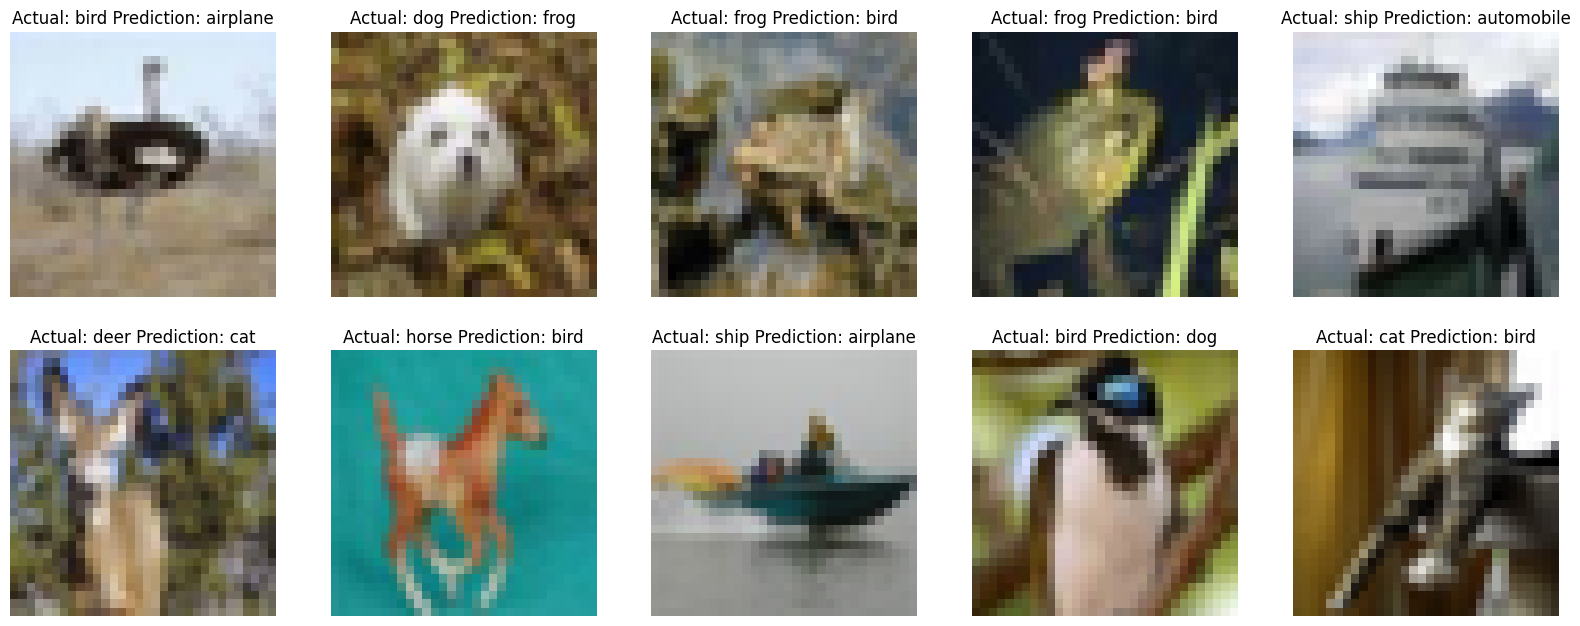

In [14]:
plot_missclassified_images(model, test_loader)